# Hyperspectral data analysis

In [4]:
import spectral.io.envi as envi
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import os
import cv2
import pandas as pd

from ipywidgets import interact
from ipywidgets import FloatSlider
from spectral import kmeans
from collections import defaultdict

os.environ["SPECTRAL_DATA"] = "C:\\Users\\ext-lugo\\Hyperspectral\\Radiance"

# Mask poles

Since hyperspectral images have a lot of bands, for easing analysis, the cells below implement a simple slider to select which band to display. Furthermore, with the new cropping algorithms and knowledge about the outliers, this should be a better process than before.

In [5]:
def mask_scan(scan, mask):
    scan = np.where(scan > 0.025, 0, scan)
    scan = np.where(mask[:,:,0] > 0, np.transpose(scan, [2,0,1]), 0)
    scan = np.transpose(scan, [1,2,0])
    
    return scan

In [17]:
def show_pole(pole_id, scan_idx):
    paths = os.listdir(os.path.join("C:\\Users\\ext-lugo\\Hyperspectral\\Radiance", str(pole_id)))
    paths = [path for path in paths if "float32.hdr" in path]
    paths.sort()
    img = envi.open(os.path.join("C:\\Users\\ext-lugo\\Hyperspectral\\Radiance", str(pole_id), paths[scan_idx])).load()
    mask = cv2.imread(os.path.join("../../Hyperspectral_masks/", f"{str(pole_id)}_{str(scan_idx)}_mask.jpg"))
    wls = np.asarray(img.metadata['wavelength'], float)
    img_show = mask_scan(img, mask)
    
    def browse_images(img):
        bands = img.shape[-1]
        def view_images(i=60):
            img_show = np.where(mask[:,:,0] > 0, np.squeeze(img[:,:,i]), 0)
            plt.imshow(img_show, cmap='gray')
            plt.title(f'{wls[i]} nm')
            plt.xticks([])
            plt.yticks([])
        interact(view_images, i=(0, bands - 1))

    browse_images(img_show)

show_pole('5', 1)

interactive(children=(IntSlider(value=60, description='i', max=99), Output()), _dom_classes=('widget-interact'…

## Spectrum analysis

In order to be able to properly characterize the wooden poles, a good starting point is to measure how the wood spectrum changes along the hyperspectral bands. Poles in different conditions are expected to show different spectrums.

Note that, in these plots, no information regarding the rotations is given, as each pole's scans are only labeled with numbers from 1 to 4, instead of the rotation degrees. The rotation could be given by comparing the scans with the RGB photos, but to keep the analysis simple, this will be omitted for now.

C:\Users\ext-lugo\AppData\Local\Temp\ipykernel_14956\1463792294.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 10, figsize=(70,7))


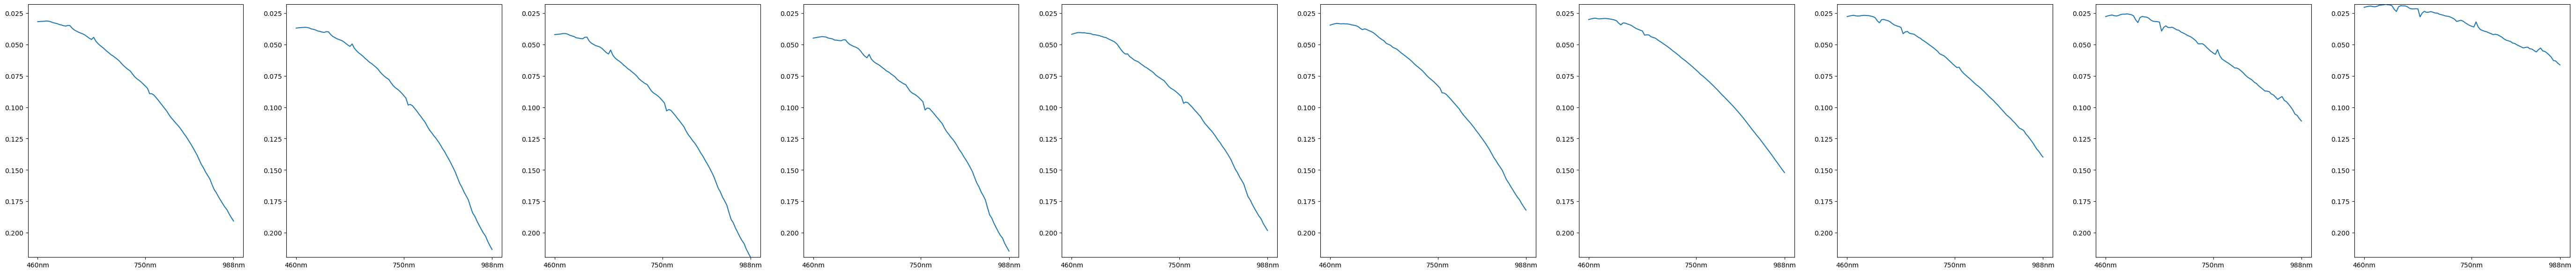

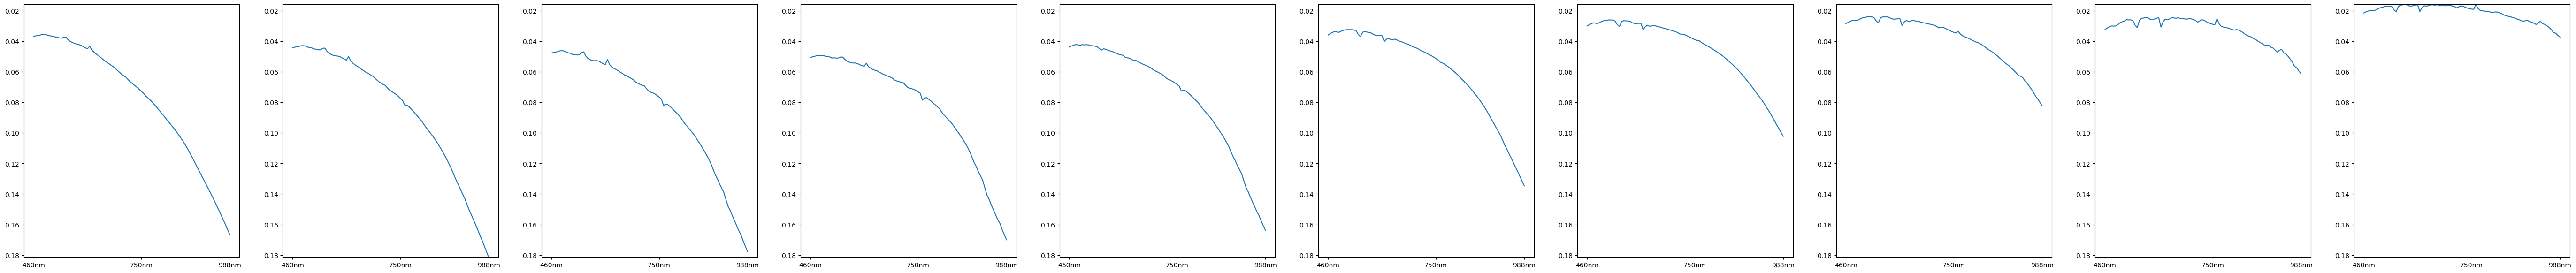

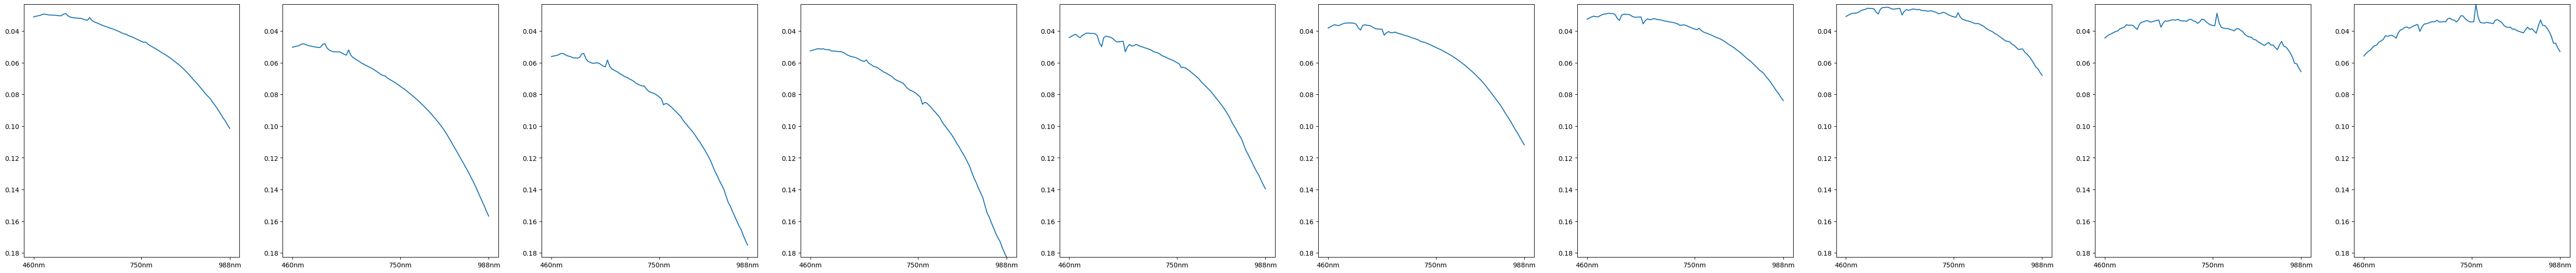

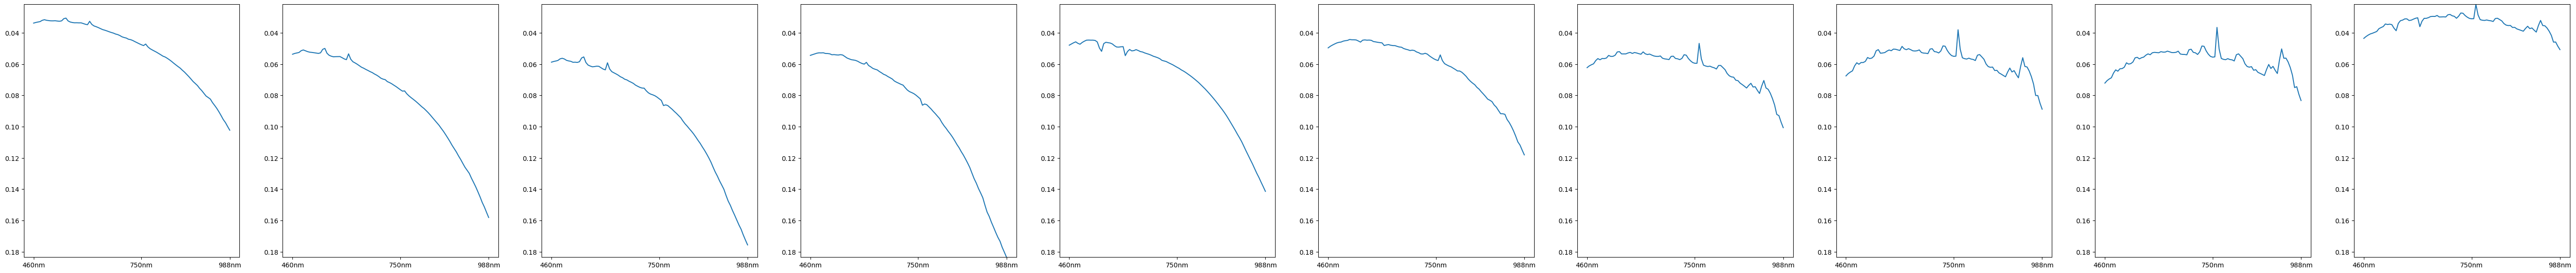

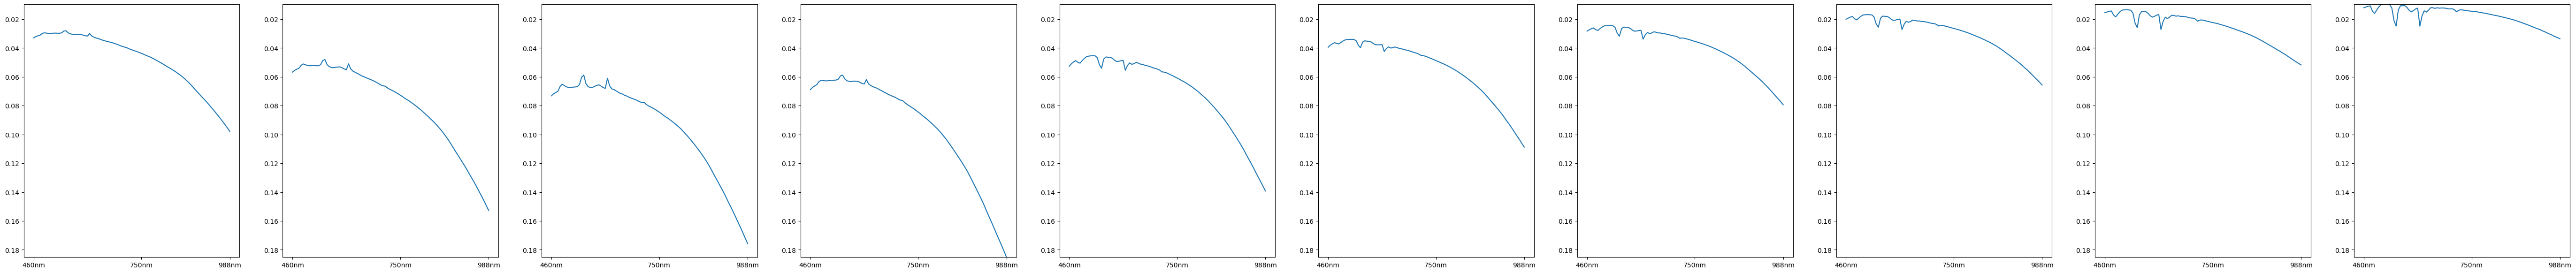

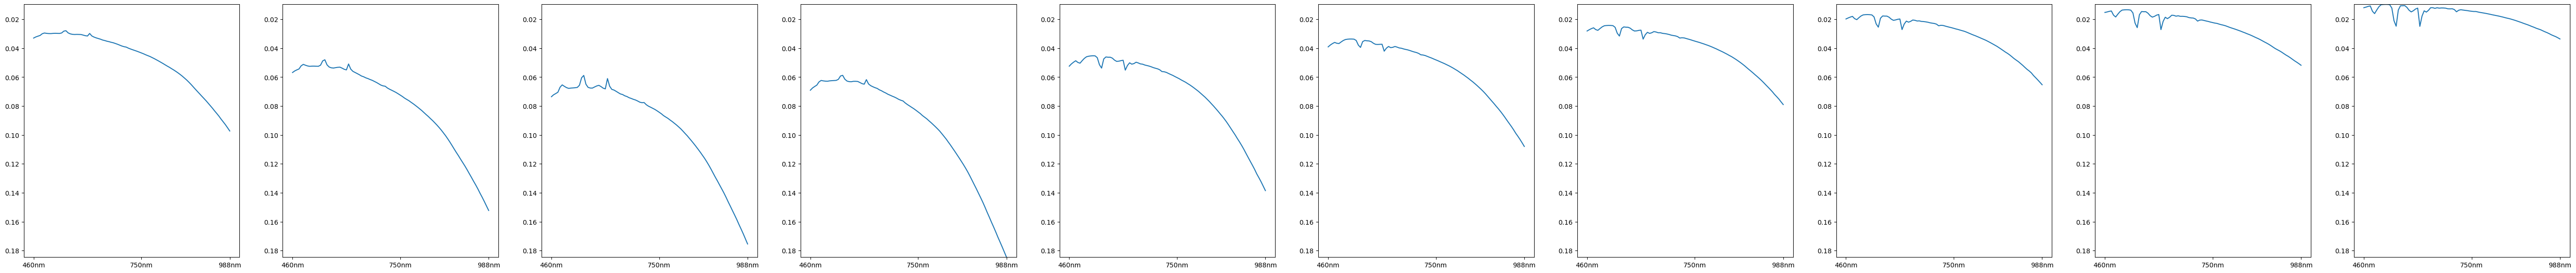

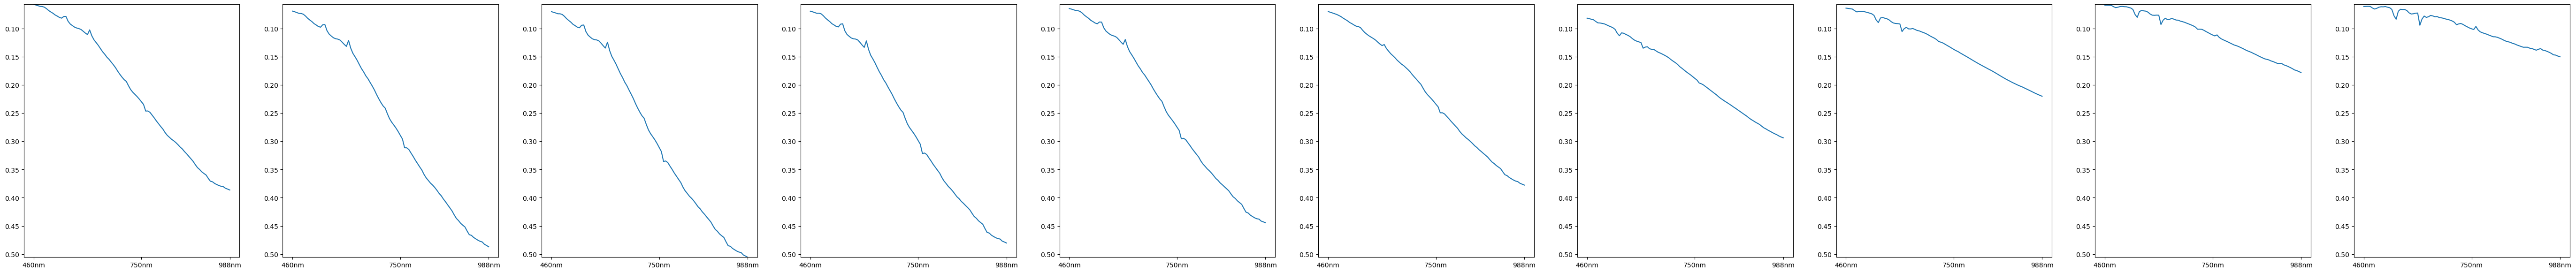

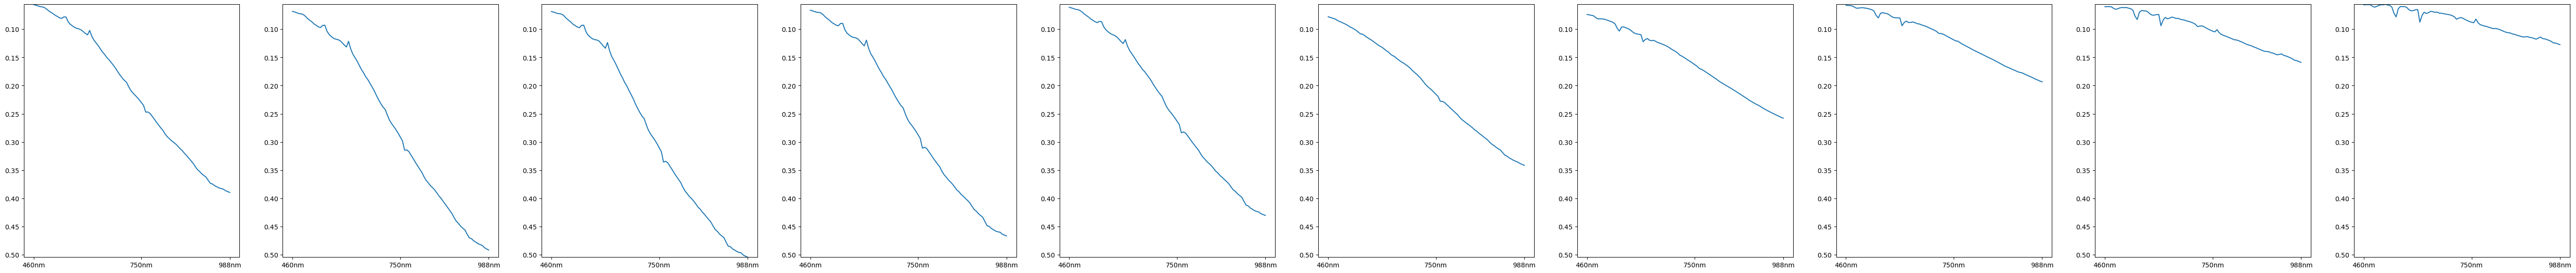

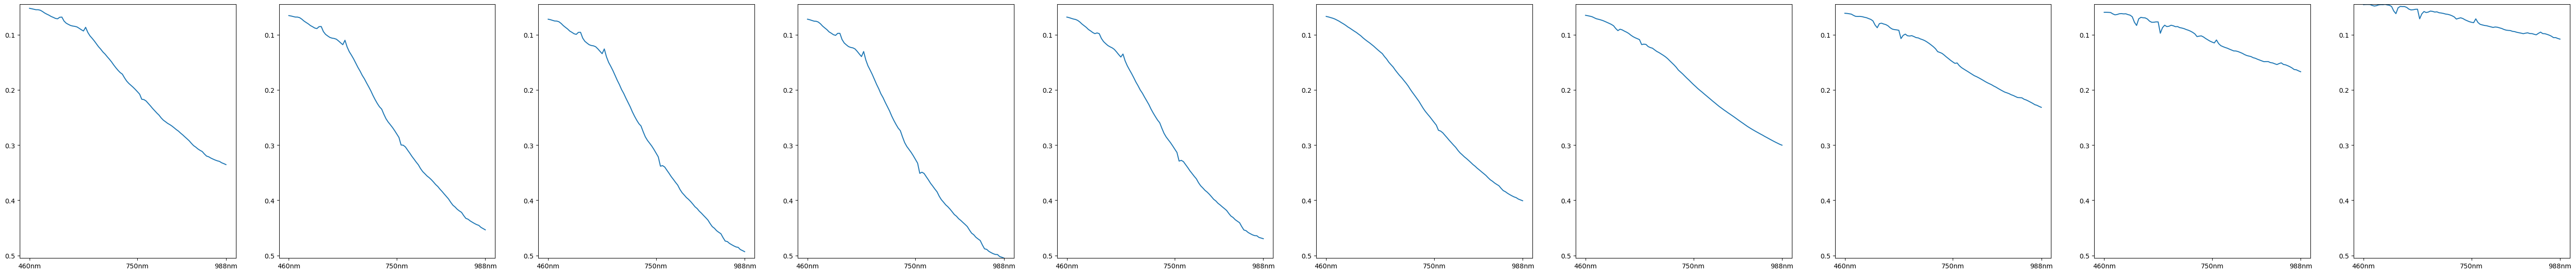

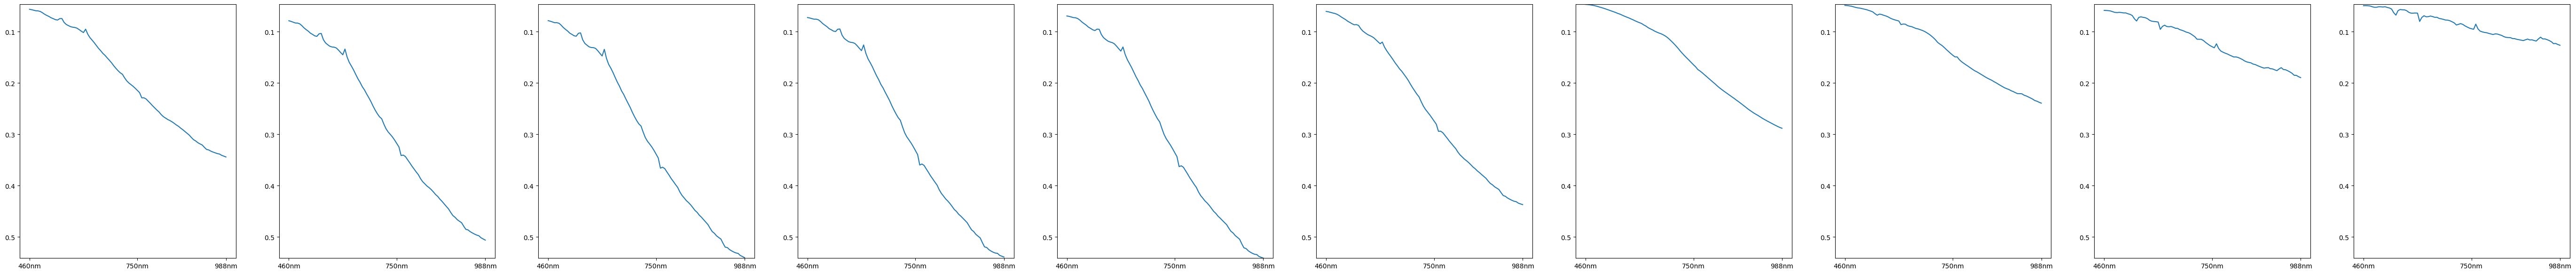

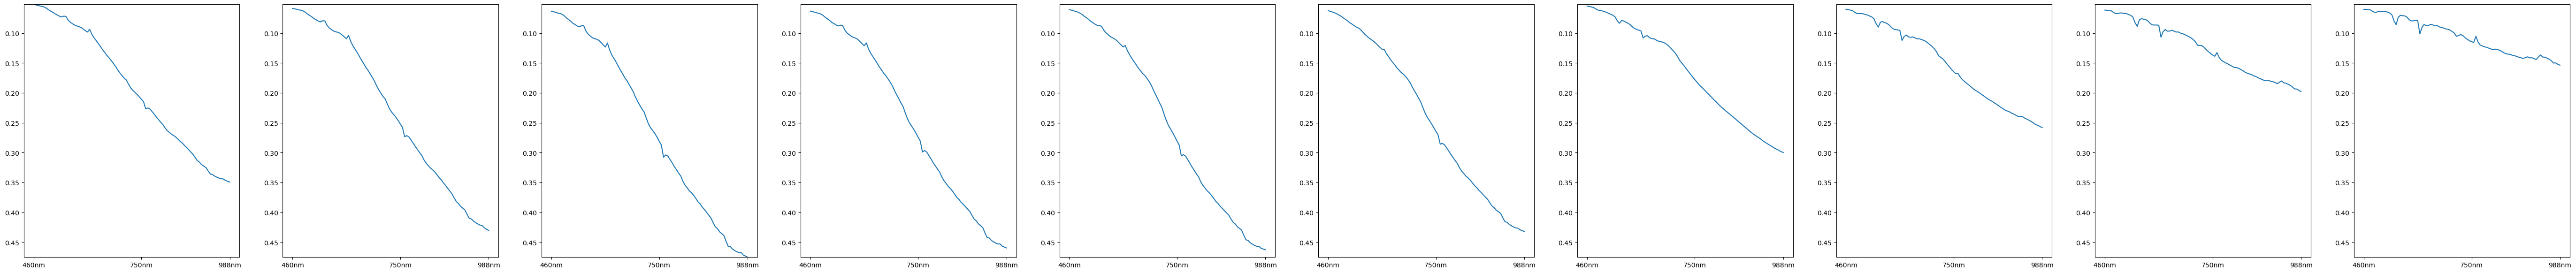

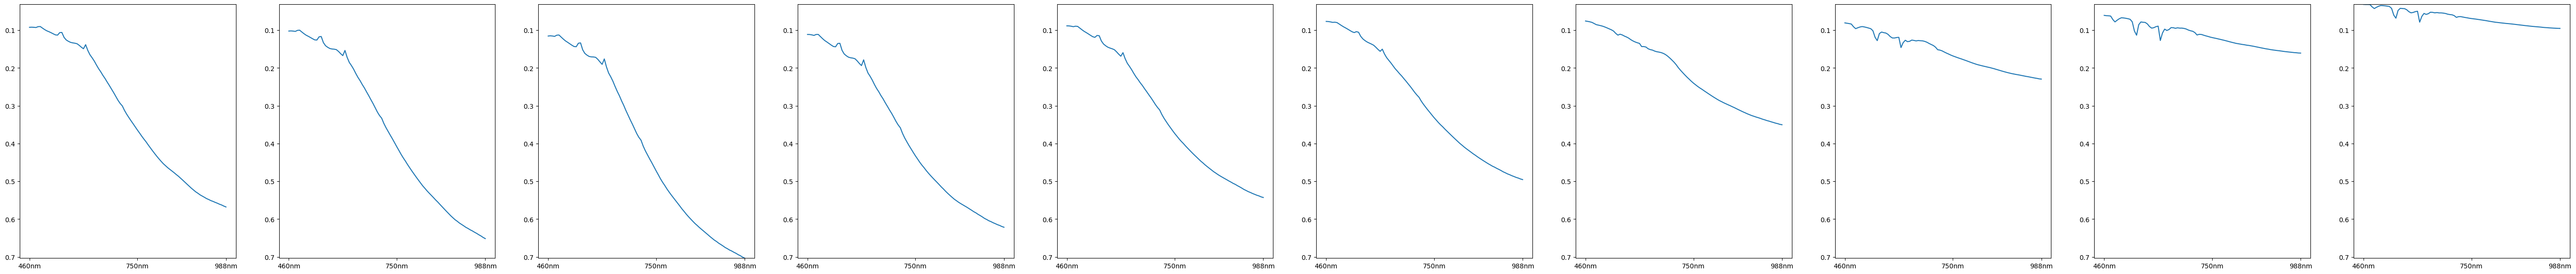

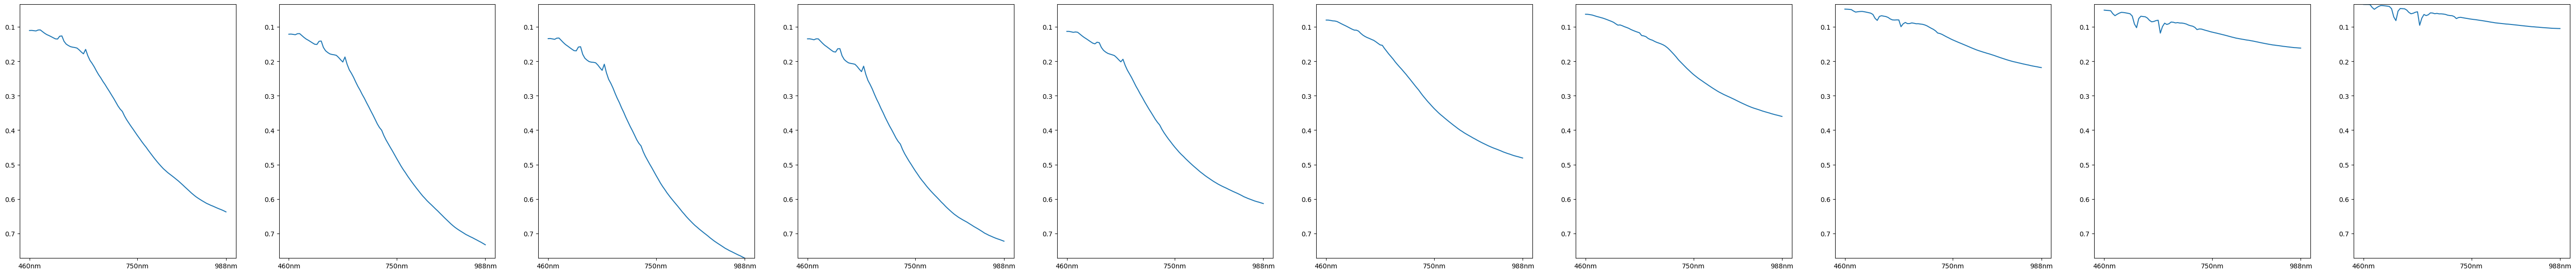

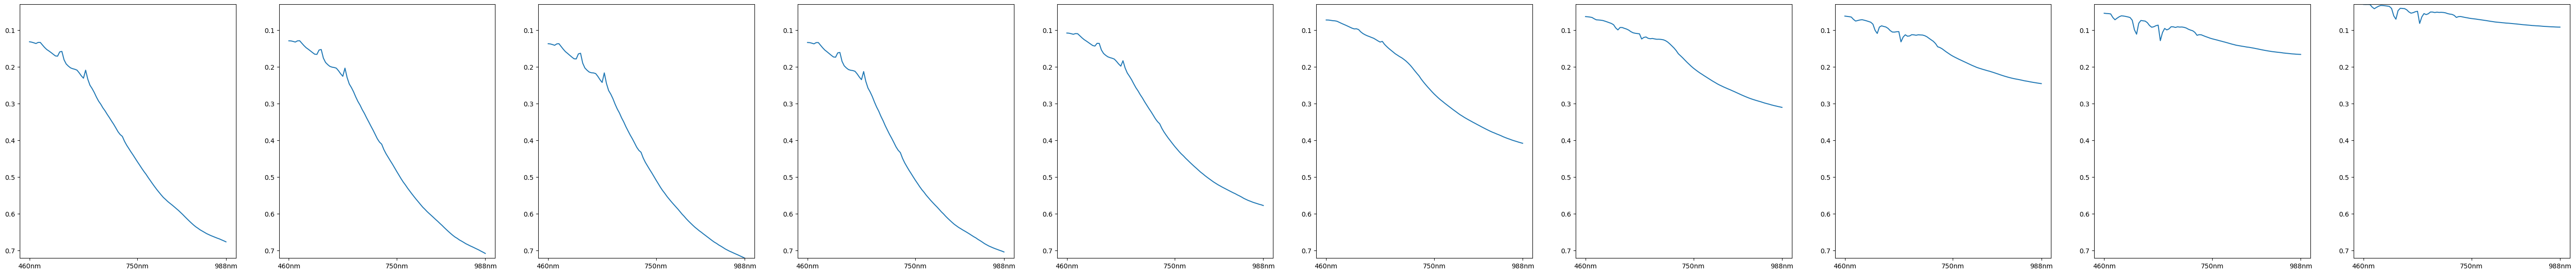

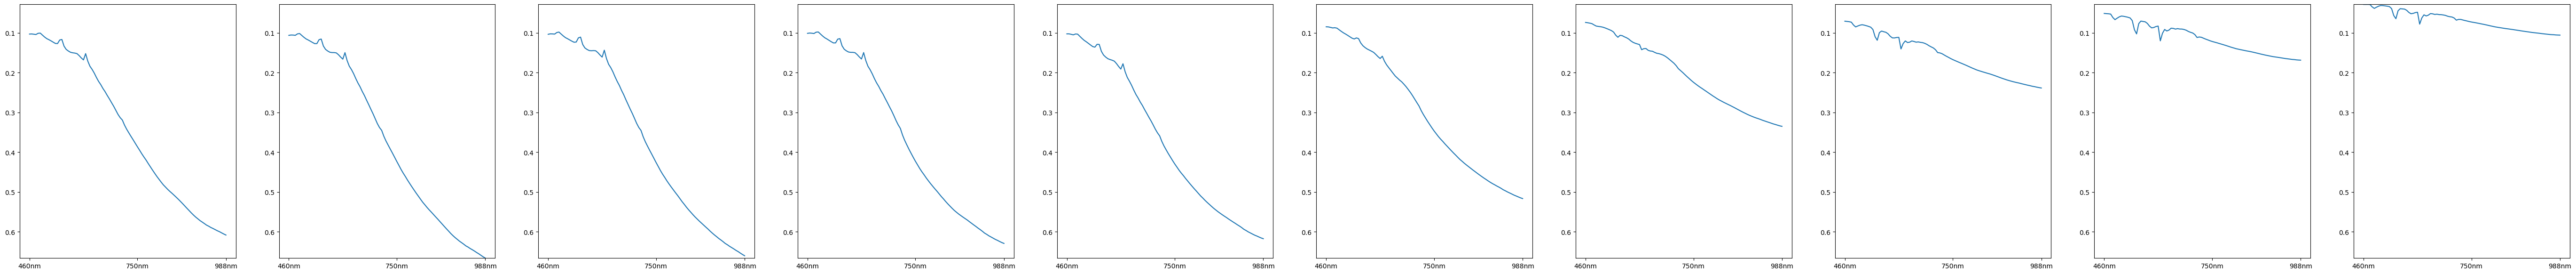

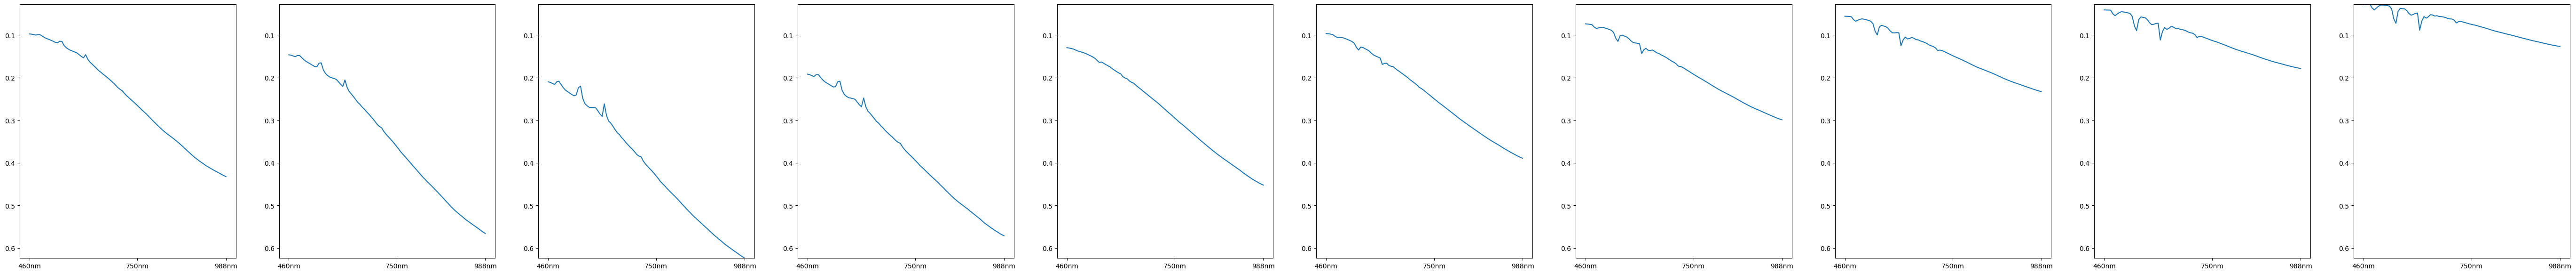

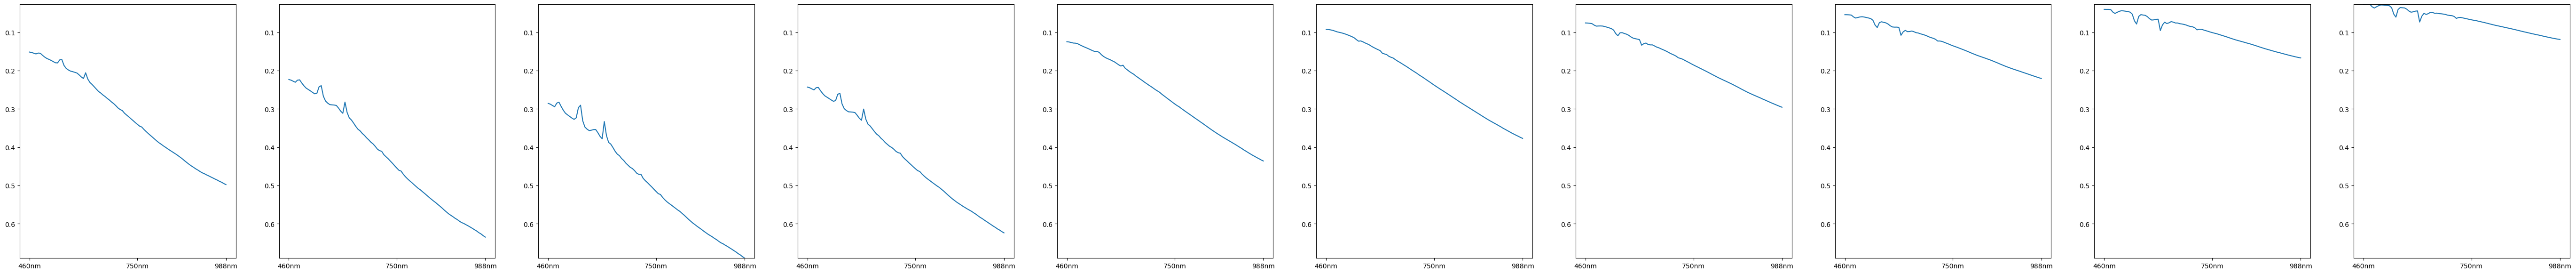

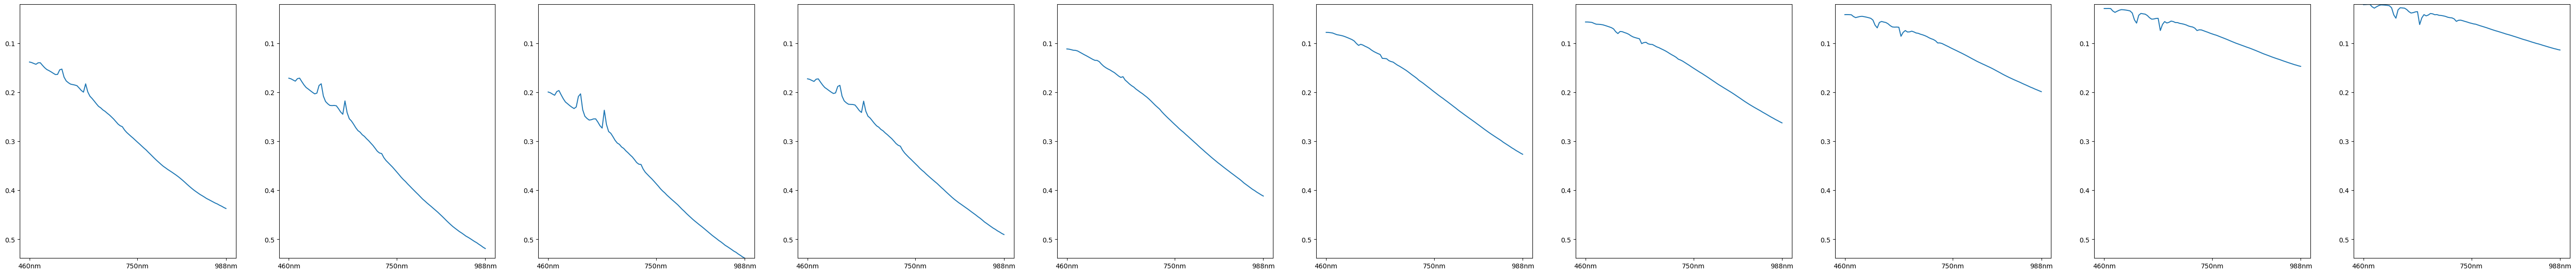

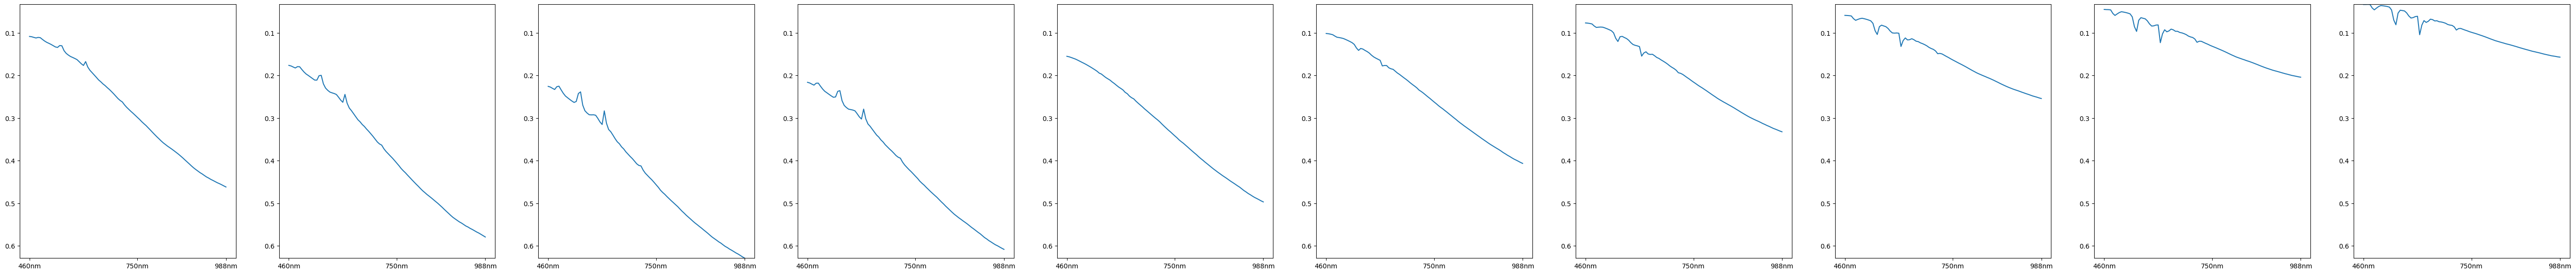

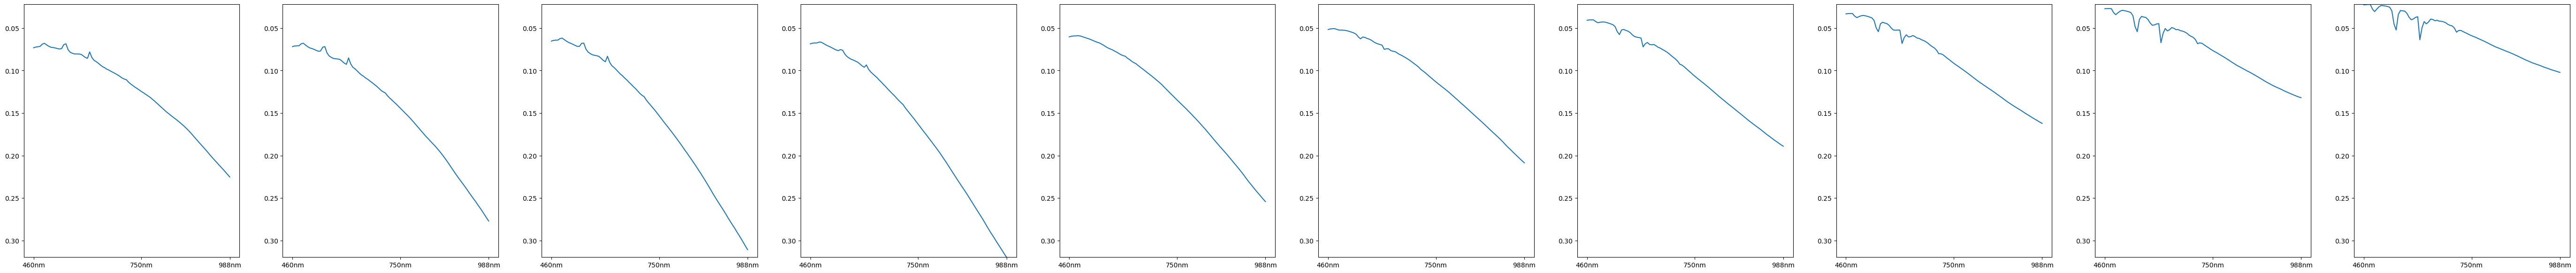

In [ ]:
def crop_pole(pole_id, scan_idx):
    paths = os.listdir(os.path.join("C:\\Users\\ext-lugo\\Hyperspectral\\Radiance", str(pole_id)))
    paths = [path for path in paths if "float32.hdr" in path]
    paths.sort()
    img = envi.open(os.path.join("C:\\Users\\ext-lugo\\Hyperspectral\\Radiance", str(pole_id), paths[scan_idx])).load()
    mask = cv2.imread(os.path.join("../../Hyperspectral_masks/", f"{str(pole_id)}_{str(scan_idx)}_mask.jpg"))
    wls = np.asarray(img.metadata['wavelength'], float)[8:]
    white = img[1800:2200,1000:1100,:]
    return mask_scan(img, mask)[...,8:], white[...,8:], wls

def resize_array(arr, final_size):
    return cv2.resize(np.array([arr], dtype=np.float32), dsize=(final_size,1))[0]

def plot_average_spectra_chunks(pole_id, scan_idx):
    # Get reflectance scan
    img, white, wls = crop_pole(pole_id, scan_idx)
    refl_img = img / np.mean(white, axis=(0,1))
    
    # Divide and get spectra
    refl_chunks = np.array_split(refl_img, 10, axis=0)
    chunks_spectra = [np.average(chunk, axis=(0,1)) for chunk in refl_chunks]
    vmax, vmin = np.max(chunks_spectra), np.min(chunks_spectra)
    
    # Plot result
    wavelength_idxs = [0, 50, 91]
    fig, axes = plt.subplots(1, 10, figsize=(70,7))
    for idx, ax in enumerate(axes):
        ax.plot(range(len(chunks_spectra[idx])), chunks_spectra[idx])
        ax.set_xticks(wavelength_idxs, [f'{wls[i]:.0f}nm' for i in wavelength_idxs])
        ax.set_ylim((vmax, vmin))
    
plot_average_spectra_chunks(0,0)
plot_average_spectra_chunks(0,1)
plot_average_spectra_chunks(0,2)
plot_average_spectra_chunks(0,3)
plot_average_spectra_chunks(0,4)
plot_average_spectra_chunks(0,5)
plot_average_spectra_chunks(5,0)
plot_average_spectra_chunks(5,1)
plot_average_spectra_chunks(5,2)
plot_average_spectra_chunks(5,3)
plot_average_spectra_chunks(5,4)
plot_average_spectra_chunks(6,0)
plot_average_spectra_chunks(6,1)
plot_average_spectra_chunks(6,2)
plot_average_spectra_chunks(6,3)
plot_average_spectra_chunks(30,0)
plot_average_spectra_chunks(30,1)
plot_average_spectra_chunks(30,2)
plot_average_spectra_chunks(30,3)
plot_average_spectra_chunks(41,0)
plot_average_spectra_chunks(41,1)
plot_average_spectra_chunks(41,2)
plot_average_spectra_chunks(41,3)

## PCA on all the scans at once

In [6]:
from sklearn.decomposition import IncrementalPCA

def get_pca_model():
    pole_ids = [0,30,41,6,5]
    pca = IncrementalPCA(n_components=10, batch_size=200)
    for pole_idx, pole_id in enumerate(pole_ids):
        paths = os.listdir(os.path.join("C:\\Users\\ext-lugo\\Hyperspectral\\Radiance", str(pole_id)))
        paths = [path for path in paths if "float32.hdr" in path]
        paths.sort()
        for scan_idx in range(len(paths)):
            print(f"Pole {pole_id}, scan number {scan_idx}")
            img = envi.open(os.path.join("C:\\Users\\ext-lugo\\Hyperspectral\\Radiance", str(pole_id), paths[scan_idx])).load()
            mask = cv2.imread(os.path.join("../../Hyperspectral_masks/", f"{str(pole_id)}_{str(scan_idx)}_mask.jpg"))
            white = img[1800:2200,1000:1100,:]
            refl_img = img / np.mean(white, axis=(0,1))
            wls = np.asarray(img.metadata['wavelength'], float)
            img_feat = mask_scan(refl_img, mask)
            
            pca.partial_fit(np.reshape(img_feat, (img_feat.shape[0] * img_feat.shape[1], img_feat.shape[2])))
            
    return pca

def plot_pca_transforms(pca):
    fig, axes = plt.subplots(5, 6, figsize=(40,12))
    pole_ids = [0,30,41,6,5]
    for pole_idx, pole_id in enumerate(pole_ids):
        paths = os.listdir(os.path.join("C:\\Users\\ext-lugo\\Hyperspectral\\Radiance", str(pole_id)))
        paths = [path for path in paths if "float32.hdr" in path]
        paths.sort()
        for scan_idx in range(len(paths)):
            print(f"Pole {pole_id}, scan number {scan_idx}")
            img = envi.open(os.path.join("C:\\Users\\ext-lugo\\Hyperspectral\\Radiance", str(pole_id), paths[scan_idx])).load()
            mask = cv2.imread(os.path.join("../../Hyperspectral_masks/", f"{str(pole_id)}_{str(scan_idx)}_mask.jpg"))
            white = img[1800:2200,1000:1100,:]
            refl_img = img / np.mean(white, axis=(0,1))
            wls = np.asarray(img.metadata['wavelength'], float)
            refl_img = mask_scan(refl_img, mask)
            
            refl_img = np.reshape(pca.transform(np.reshape(refl_img, (refl_img.shape[0] * refl_img.shape[1], refl_img.shape[2]))), (refl_img.shape[0], refl_img.shape[1], 10))
            refl_img[:,:,1] = np.interp(refl_img[:,:,1], (np.min(refl_img[:,:,1]), np.max(refl_img[:,:,1])), (0,1))
            refl_img[:,:,2] = np.interp(refl_img[:,:,2], (np.min(refl_img[:,:,2]), np.max(refl_img[:,:,2])), (0,1))
            refl_img[:,:,3] = np.interp(refl_img[:,:,3], (np.min(refl_img[:,:,3]), np.max(refl_img[:,:,3])), (0,1))
            axes[pole_idx, scan_idx].imshow(refl_img[...,:3])
            
    fig.suptitle('Hyperspectral chemical variation and PCA')

    [axes[0,i].set_title(f'Image #{i}') for i in range(6)]

In [7]:
pca = get_pca_model()

Pole 0, scan number 0
Pole 0, scan number 1
Pole 0, scan number 2
Pole 0, scan number 3
Pole 0, scan number 4
Pole 0, scan number 5
Pole 30, scan number 0
Pole 30, scan number 1
Pole 30, scan number 2
Pole 30, scan number 3
Pole 41, scan number 0
Pole 41, scan number 1
Pole 41, scan number 2
Pole 41, scan number 3
Pole 6, scan number 0
Pole 6, scan number 1
Pole 6, scan number 2
Pole 6, scan number 3
Pole 5, scan number 0
Pole 5, scan number 1
Pole 5, scan number 2
Pole 5, scan number 3
Pole 5, scan number 4


Pole 0, scan number 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pole 0, scan number 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pole 0, scan number 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pole 0, scan number 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pole 0, scan number 4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pole 0, scan number 5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pole 30, scan number 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pole 30, scan number 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pole 30, scan number 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pole 30, scan number 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pole 41, scan number 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pole 41, scan number 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pole 41, scan number 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pole 41, scan number 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pole 6, scan number 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pole 6, scan number 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pole 6, scan number 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pole 6, scan number 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pole 5, scan number 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pole 5, scan number 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pole 5, scan number 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pole 5, scan number 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pole 5, scan number 4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


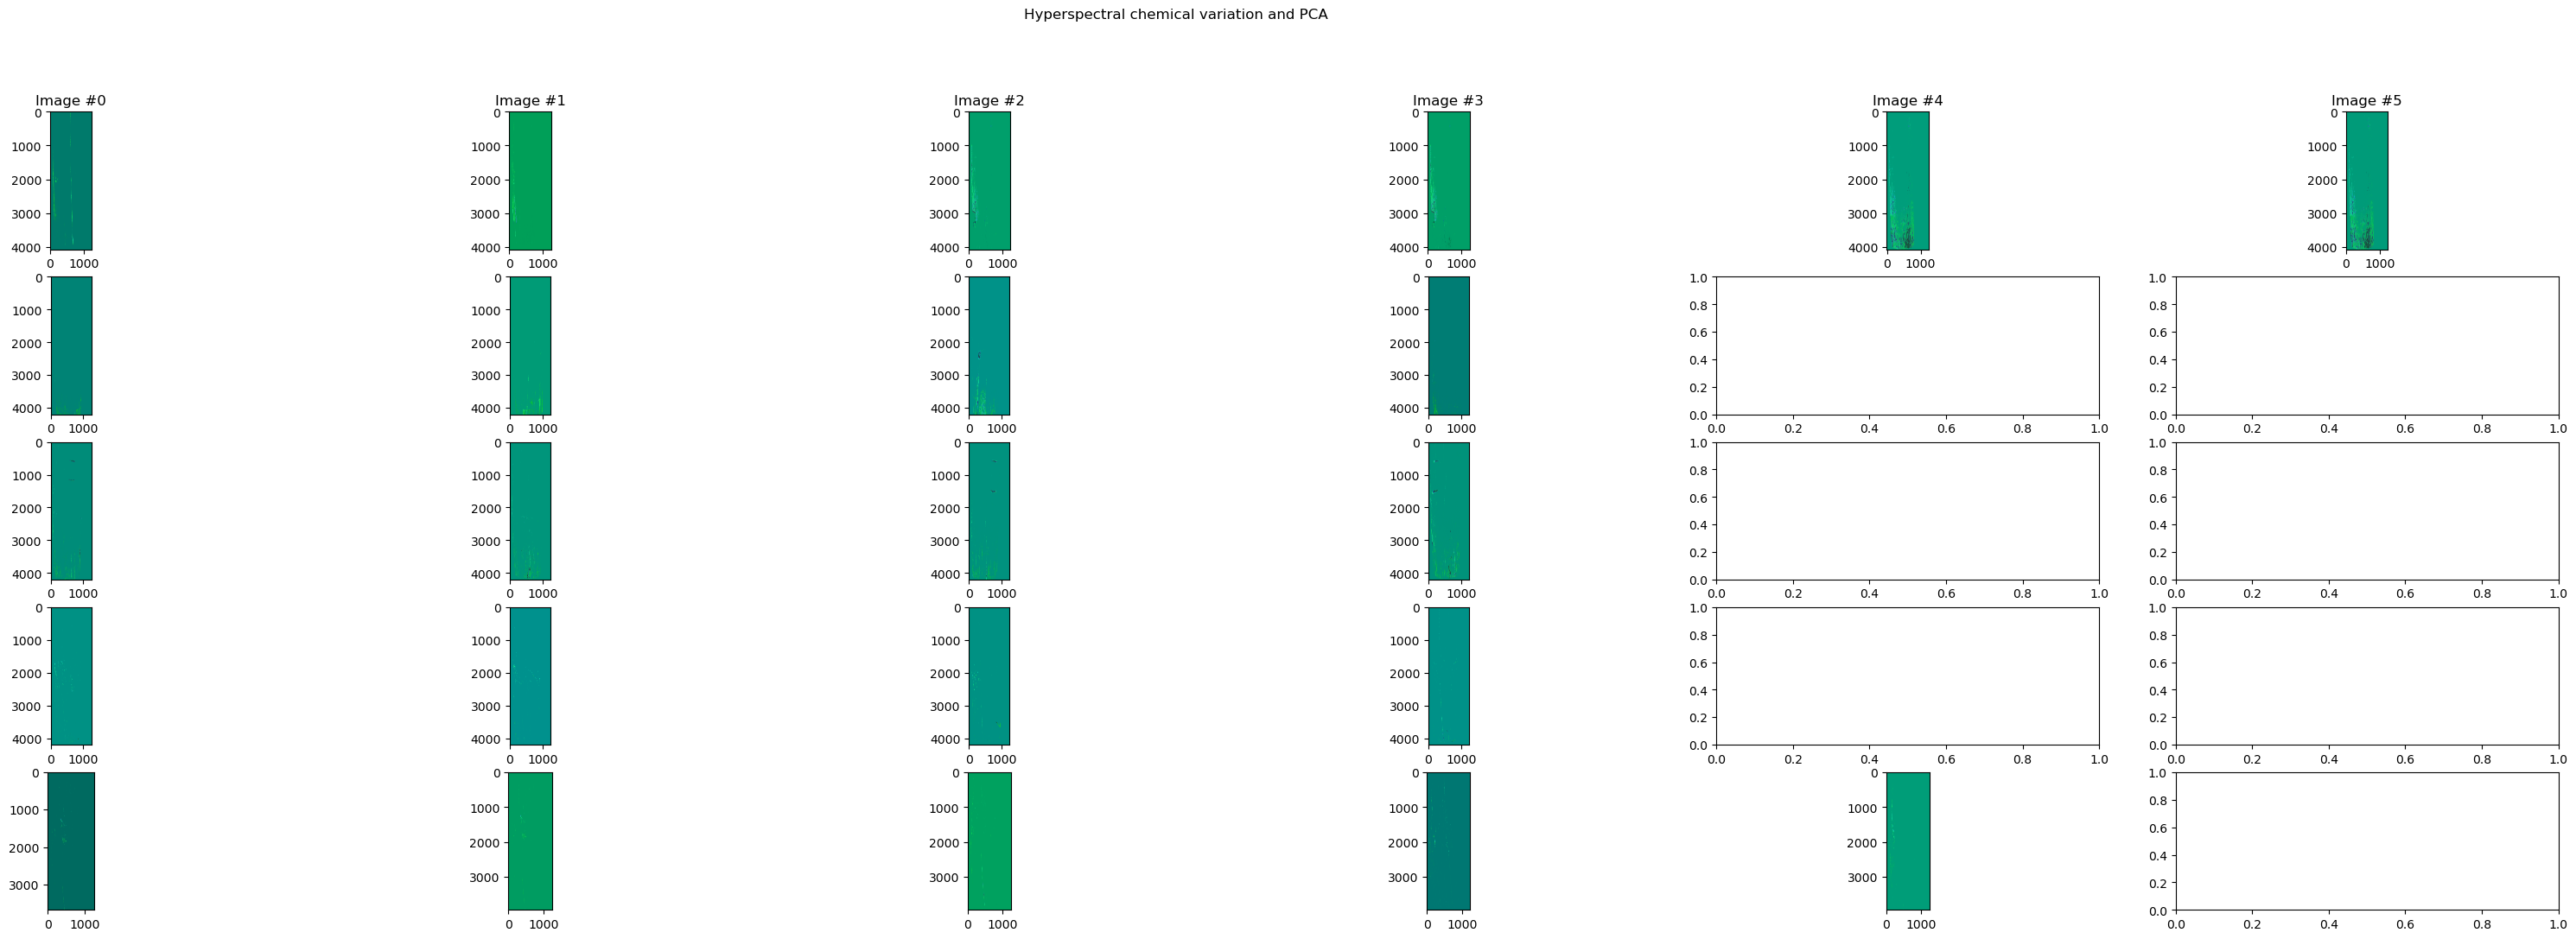

In [8]:
plot_pca_transforms(pca)